In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'
    
    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)
    
    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'
        
    js_f_name = f'code_toggle_{random.randint(1,2**64)}'
        
    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}
            
            {js_hide_current}
        </script>
        
        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )
    
    return HTML(html)

hide_toggle()

# PyCon 2018: Alon Nir - Network analysis in Python

# Small example

### Create a simple NetworkX graph

In [2]:
import networkx as nx

# lots of options to create a graph

##### Create from edge list

In [3]:
g = nx.from_edgelist([
    (0, 1),
    (1, 2),
    (1, 0),
    (3, 0)
], create_using=nx.DiGraph())

In [4]:
node_attrs = {
    0: {'name': 'john'},
    1: {'name': 'karl'},
    2: {'name': 'tessa'},
}

nx.set_node_attributes(g, node_attrs)

##### Easy and intuitive to inspect

In [5]:
g.nodes[0]

{'name': 'john'}

In [6]:
nx.get_node_attributes(g, 'name')

{0: 'john', 1: 'karl', 2: 'tessa'}

### Visualise it!

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
nx.draw_networkx(
    g, 
    node_size=500, 
    font_size=16, 
    node_color='g', 
    alpha=.5,
    arrowsize=40,
    labels=nx.get_node_attributes(g, 'name'),
    pos=nx.spring_layout(g, k=1))
plt.gca().axis('off');

hide_toggle()

# Bigger example

### Load some more data as Pandas dataframe

In [8]:
# data on co-authoring papers in astrophysics (Arxiv)
# (data from Kaggle https://www.kaggle.com/charlesxjyang/arxiv-astrophysics-collab)

import pandas as pd

df = pd.read_csv('data/ca-AstroPh.csv', skiprows=4)
df.columns = ['from_id', 'to_id']
df.head()

,from_id,to_id
0,84424,276
1,84424,1662
2,84424,5089
3,84424,6058
4,84424,6229


In [9]:
df.shape

(396160, 2)

### Create a NetworkX graph from the dataframe

In [10]:
g = nx.from_pandas_edgelist(df, 'from_id', 'to_id')

In [11]:
print(f'Nodes: {nx.number_of_nodes(g)}')
print(f'Edges: {nx.number_of_edges(g)}')
print(f'Isolates: {nx.number_of_isolates(g)}')

Nodes: 18772
Edges: 198110
Isolates: 0


In [12]:
# this would be too much to draw! Would take a while too

# nx.draw_networkx(g, node_size=10, font_size=16, node_color='g', alpha=.5, pos=nx.spring_layout(g, k=1))

### Take a subset of the graph

In [13]:
subset = list(g.nodes)[:100]  # first 100 nodes
g_sub = g.subgraph(subset)

In [14]:
def draw(g, pos):  # pos specifies type of drawing
    plt.figure(figsize=(12, 8))
    nx.draw_networkx(g, node_size=500, font_size=16, node_color='g', alpha=.5, pos=pos)
    plt.gca().axis('off');

Let's look at the types of drawings...

### Visualise - circular

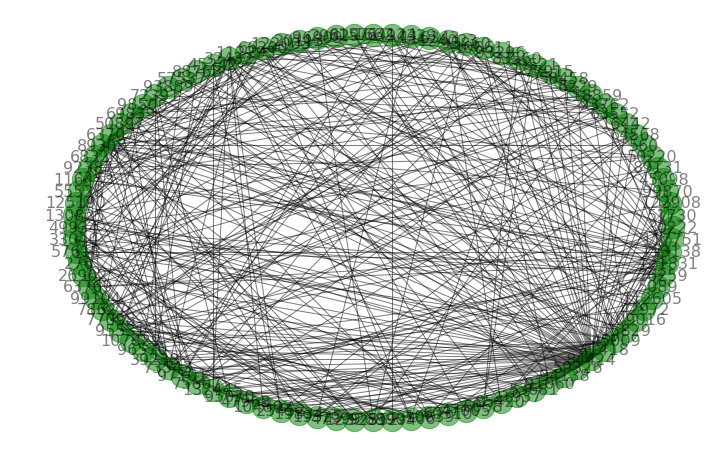

In [15]:
draw(g_sub, nx.circular_layout(g_sub))

### Spring layout (Fruchterman-Reingold)

"...drawing graphs in an aesthetically-pleasing way. Their purpose is to position the nodes of a graph in two-dimensional or three-dimensional space so that all the edges are of more or less equal length and there are as few crossing edges as possible..."

##### K = 1

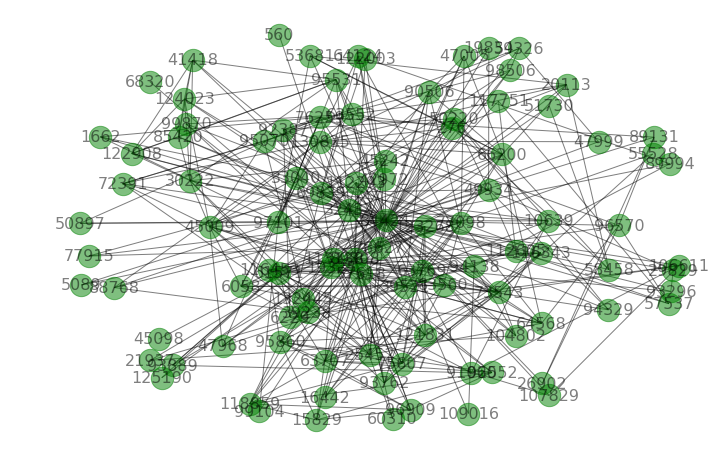

In [16]:
draw(g_sub, nx.spring_layout(g_sub, k=1))

##### K = 4

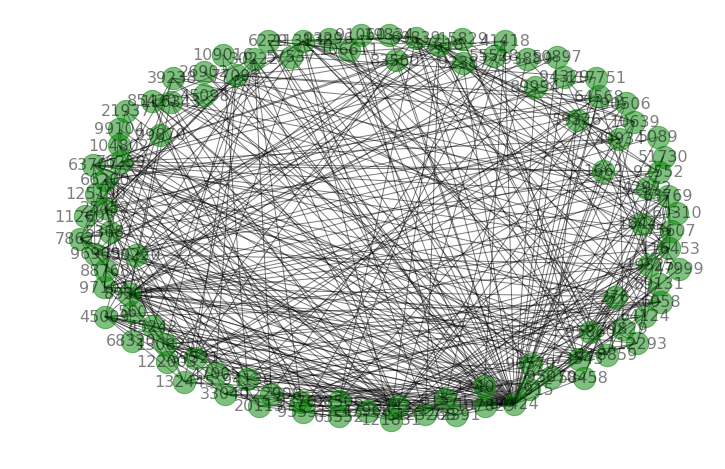

In [17]:
draw(g_sub, nx.spring_layout(g_sub, k=4))  # k controls how much to spread nodes apart

### Kamada Kawai layout

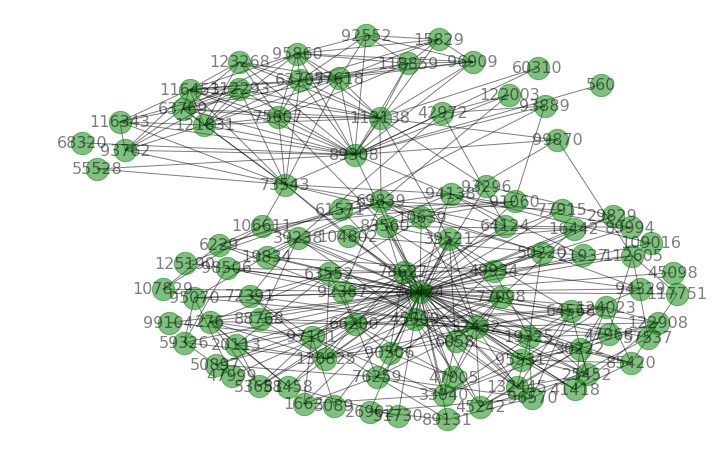

In [18]:
# edges represent springs, that want to be not too stretched or compressed
# http://www.uta.fi/sis/mtt/mtts1-dimensionality_reduction/drv_lecture13.pdf
draw(g_sub, nx.kamada_kawai_layout(g_sub))

# Connected components

In [19]:
ccs = list(nx.connected_components(g))

print(f'{len(ccs)} connected components!')

290 connected components!


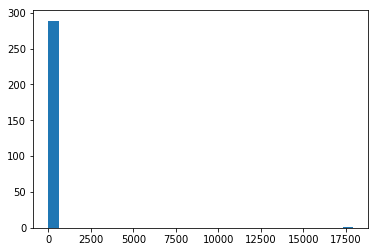

In [20]:
lenghts = list(map(len, ccs))
bars = plt.hist(lenghts, bins=30)

In [21]:
bars[0]

array([289.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.])

# Algorithms - community detection

The Girvan–Newman algorithm detects communities by **progressively removing edges from the original graph. The algorithm removes the “most valuable” edge, traditionally the edge with the highest betweenness centrality**, at each step. As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram

In [22]:
g_sub = g.subgraph(list(g.nodes)[130:160])

In [23]:
# returns a list of increasingly granular tuples of communities
# - i.e. first item splits the nodes into K communities (where K is number of connected components)
# - second item splits the nodes into K + 1 communites etc..
communities = list(nx.algorithms.community.centrality.girvan_newman(g_sub))

In [24]:
node2community = {node_id: i for i, community in enumerate(communities[5]) for node_id in community}

In [25]:
hide_toggle(for_next=True)

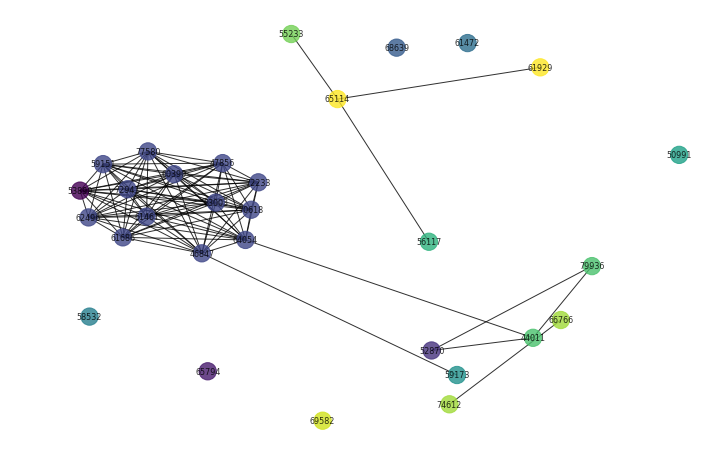

In [26]:
plt.figure(figsize=(12, 8))
nx.draw_networkx(
    g_sub, 
    node_size=300, 
    font_size=8, 
    alpha=.8, 
    pos=nx.spring_layout(g_sub, k=1), 
    node_color=[node2community[n] for n in g_sub.nodes]
)
plt.gca().axis('off');

### Using package python-louvain (much faster)

**Louvain method**

The method is a **greedy** optimization method that attempts to optimize the "modularity" of a partition of the network. (Modularity is the fraction of the edges that fall within the given groups minus the expected fraction if edges were distributed at random)

First, the method **looks for "small" communities** by optimizing modularity locally. Second, it **aggregates nodes belonging to the same community** and builds a new network whose nodes are the communities

https://perso.uclouvain.be/vincent.blondel/research/louvain.html

Number of communities: 11


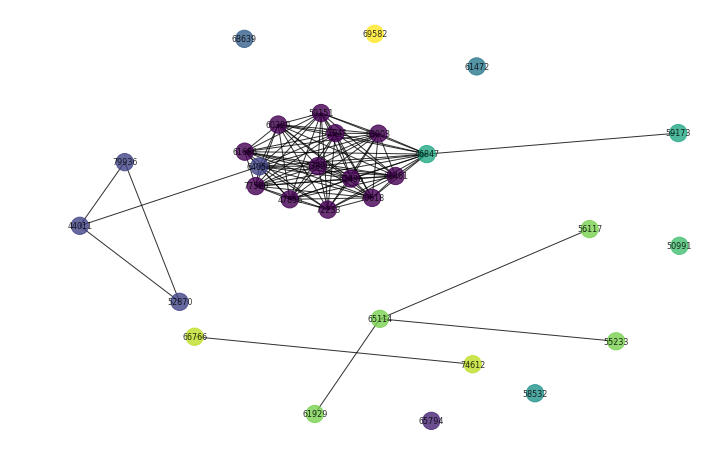

In [27]:
import community

communities = community.best_partition(g_sub, resolution=.9)
print('Number of communities: {}'.format(len(set(communities.values()))))

plt.figure(figsize=(12, 8))
nx.draw_networkx(
    g_sub, 
    node_size=300, 
    font_size=8, 
    alpha=.8, 
    pos=nx.spring_layout(g_sub, k=1), 
    node_color=[communities[n] for n in g_sub.nodes]
)
plt.gca().axis('off');

hide_toggle()

# PageRank

Compute page rank

In [28]:
g_sub = g.subgraph(list(g.nodes)[0:30])

In [29]:
pr = nx.pagerank(g_sub)

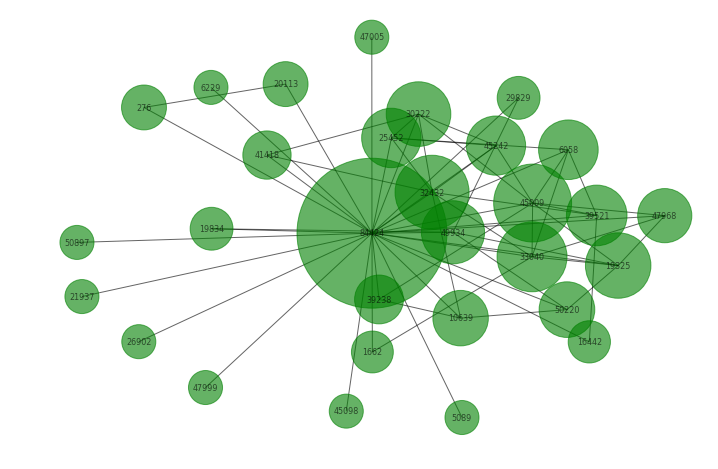

In [30]:
plt.figure(figsize=(12, 8))
nx.draw_networkx(
    g_sub, 
    node_size=[100000*pr[n] for n in g_sub.nodes()], 
    font_size=8, 
    alpha=.6, 
    pos=nx.spring_layout(g_sub, k=1), 
    node_color='g'
)
plt.gca().axis('off');

hide_toggle()